In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/bike_recognition"

brand.csv  data.zip  main.ipynb


In [ ]:
#!unzip '/content/drive/My Drive/bike_recognition/data.zip' -d '/content/drive/My Drive/bike_recognition/'

In [2]:
%cd "/content/drive/My Drive/bike_recognition/"

/content/drive/My Drive/bike_recognition


In [ ]:
import os 
len(os.listdir('/content/drive/My Drive/bike_recognition/data/'))

In [5]:
import pandas as pd
import tensorflow as tf
from numpy import array
from keras.applications.vgg19 import preprocess_input
from numpy import argmax
from tensorflow.keras import utils

IMAGE_SIZE = [224, 224]

def make_dataset(csv_path, dir_path, batch_size, IMAGE_SIZE):
    def parse_image(filename):
        image = tf.io.read_file(dir_path + "/" + filename)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = preprocess_input(image)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    data = pd.read_csv(csv_path)
    data = pd.DataFrame(data=data)
    filenames = list(data["image_url"])
    classes = ["Specialized", "Trek", "Cannondale", "Giant"]
    typs = list(data["brand"])
    labels = [classes.index(typ) for typ in typs]
    labels = array(labels)
    labels = utils.to_categorical(labels, num_classes=4)
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)
    ds = ds.apply(tf.data.experimental.ignore_errors())

    return ds

In [5]:
dataset = make_dataset("/content/drive/My Drive/bike_recognition/brand.csv", "/content/drive/My Drive/bike_recognition", 128, IMAGE_SIZE)

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Dropout, AveragePooling2D
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

In [9]:

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_initializer='random_uniform', bias_initializer='random_uniform', bias_regularizer=regularizers.l2(0.01), name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
base_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=0.0003, decay=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
test_set = dataset.take(62) 
train_set = dataset.skip(62)

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau


checkpoint = ModelCheckpoint("brand.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max',save_freq ="epoch")
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1)

filename='log.csv'
history_logger=CSVLogger(filename, separator=",", append=True)

start = datetime.now()

model_history=model.fit(
    train_set,
    validation_data=test_set,
    epochs=50,
    shuffle=True,
    callbacks=[checkpoint,reduce_lr,history_logger],
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

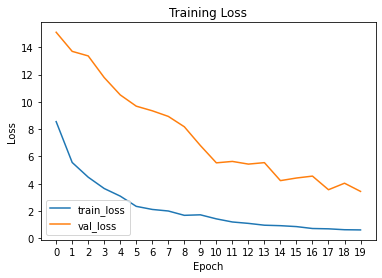

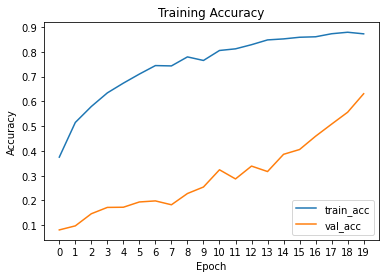

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
history=pd.read_csv('log.csv')
N = 20
plt.xticks(np.arange(0, N))
plt.plot(np.arange(0, N), history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
plt.figure()
plt.xticks(np.arange(0, N))
plt.plot(np.arange(0, N), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc ="lower right")
plt.show()